# Neural Networks for EMNIST 

#### YouTube Link:

#### Description:
These next few weeks we will walk through the complete development of a Neural Network Project, focused on the Extended MNIST (EMNIST) dataset (https://www.nist.gov/itl/iad/image-group/emnist-dataset), as explored in Yann Lecun's site: http://yann.lecun.com/exdb/mnist/. 

Overview:
- Load Data
- Prepare Data
- Define and Compile Model
- Train Model
- Inspect Model performance with Tensorboard

Coming Soon:
- Model construction
    - Dense Layers
    - Convolutional Layers

#### References: 
- **Callbacks**: 
    - Machine Learning Mastery: https://machinelearningmastery.com/check-point-deep-learning-models-keras/
    - Keras Documentation: https://keras.io/callbacks/
- (Last semester reference): http://localhost:8889/notebooks/03.19%20Introduction%20to%20Keras%20Pt%202%20-%20Mijael/Keras_mnist_cnn.ipynb)


### _Initialize_ 

In [23]:
#!/usr/bin/env python3

import gzip
import matplotlib.pyplot as plt
import numpy as np
import struct
import os
import random

#JustKerasThings~
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
# from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras import backend


%matplotlib inline

In [2]:
# Project Path: NOTE: Change to your username before use!
project_path = '/Users/shegocaga/TDS/TDS-python-nn-18-fall/lecture_materials/2018-10-15 The EMNIST Dataset/'

# Folder containing EMNIST download:
download_path = project_path + 'gzip/'

## Load Dataset

In [3]:
def read_idx(filename):
    # the idx file format can be found at the bottom of http://yann.lecun.com/exdb/mnist/
    print('Processing data from %s.' % filename)
    with gzip.open(filename, 'rb') as f:
        # read the "magic number" first
        z, dtype, dim = struct.unpack('>HBB', f.read(4))
        print("Dimensions:", dim)
        # get the shape (size in each dimension) of the data
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
        print("Shape:", shape)
        # return the data as a reshaped numpy array
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
def load_emnist():
    # the dataset can be found here: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
    train_images = download_path + 'emnist-byclass-train-images-idx3-ubyte.gz'
    train_labels = download_path + 'emnist-byclass-train-labels-idx1-ubyte.gz'
    test_images = download_path + 'emnist-byclass-test-images-idx3-ubyte.gz'
    test_labels = download_path + 'emnist-byclass-test-labels-idx1-ubyte.gz'

    train_X = read_idx(train_images)
    train_y = read_idx(train_labels)
    test_X = read_idx(test_images)
    test_y = read_idx(test_labels)

    return (train_X, train_y, test_X, test_y)

In [5]:
raw_train_X, raw_train_y, raw_test_X, raw_test_y = load_emnist();

Processing data from /Users/shegocaga/TDS/TDS-python-nn-18-fall/lecture_materials/2018-10-15 The EMNIST Dataset/gzip/emnist-byclass-train-images-idx3-ubyte.gz.
Dimensions: 3
Shape: (697932, 28, 28)
Processing data from /Users/shegocaga/TDS/TDS-python-nn-18-fall/lecture_materials/2018-10-15 The EMNIST Dataset/gzip/emnist-byclass-train-labels-idx1-ubyte.gz.
Dimensions: 1
Shape: (697932,)
Processing data from /Users/shegocaga/TDS/TDS-python-nn-18-fall/lecture_materials/2018-10-15 The EMNIST Dataset/gzip/emnist-byclass-test-images-idx3-ubyte.gz.
Dimensions: 3
Shape: (116323, 28, 28)
Processing data from /Users/shegocaga/TDS/TDS-python-nn-18-fall/lecture_materials/2018-10-15 The EMNIST Dataset/gzip/emnist-byclass-test-labels-idx1-ubyte.gz.
Dimensions: 1
Shape: (116323,)


### Visualize the dataset

In [6]:
print(raw_train_X.shape)

(697932, 28, 28)


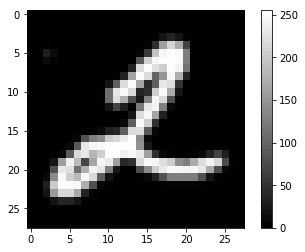

In [7]:
%matplotlib inline

plt.imshow(raw_train_X[55].T, cmap='gray')
plt.colorbar()
plt.show()

In [8]:
%matplotlib tk

# Scrolling visualizer
# fig, ax = plt.subplots()
# for x in range(raw_train_X.shape[0]):
#     ax.clear()
#     ax.imshow([i for i in 255 - raw_train_X[x].T], cmap='gray')
#     title = 'label = %d = %s' % (raw_train_y[x], labels[raw_train_y[x]])
#     ax.set_title(title, fontsize=20)
#     plt.pause(1)

---

## Prepare Data + Labels

### Data Shape!
_Inputs for models must be 1-D arrays!_ (luckily Keras takes care of this for us)

In [9]:
#keras.backend.image_data_format()

In [10]:
# Shape of the datasets
print('train_X shape: ', raw_train_X.shape)
print('train_y shape: ', raw_train_y.shape)
print('test_X shape: ', raw_test_X.shape)
print('test_y shape: ', raw_test_y.shape)

train_X shape:  (697932, 28, 28)
train_y shape:  (697932,)
test_X shape:  (116323, 28, 28)
test_y shape:  (116323,)


In [11]:
# Save the dimensions of the input images
img_height = len(raw_train_X[0])
img_width = len(raw_train_X[1])
input_shape = img_height*img_width

print('Original Image Dimensions: ', img_height, img_width)
print('Flattened image length: ', input_shape)

Original Image Dimensions:  28 28
Flattened image length:  784


In [12]:
train_X = raw_train_X.reshape(len(raw_train_X), input_shape)
test_X = raw_test_X.reshape(len(raw_test_X), input_shape)

print('Training dataset shape: ', train_X.shape)
print('Model input shape: ', input_shape)

Training dataset shape:  (697932, 784)
Model input shape:  784


### Data Normalization

In [14]:
# Values start as integers:
print(train_X.dtype)

# Set as float32's
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

# Normalize! 
train_X /= 255
test_X /= 255

print('Flattened length of numpy data array: ',img_height*img_width)

uint8
Flattened length of numpy data array:  784


### Labels: One-hot encode

In [39]:
# Label (category) Mapping:
labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
label_vec = labels.split()

# Save number of categories
n_cat = len(labels)

print('Number of categories: ', n_cat)
print(labels[-1])

Number of categories:  62
z


In [16]:
train_y = keras.utils.np_utils.to_categorical(raw_train_y)
test_y = keras.utils.np_utils.to_categorical(raw_test_y)
print('One-hot encoded label dimensions: ', test_y.shape)
test_y

One-hot encoded label dimensions:  (116323, 62)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

---

## Model Building
Note that keras.layers.dense requires a flattened array as an input. This model does this automatically, provided the proper dimensions. 

### Define the Model

In [17]:
model = keras.models.Sequential()
model.add(Dense(16, input_dim=input_shape, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(n_cat, activation='softmax'))

### Compile the Model

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

---

## Train Model

### Save state of training using callbacks:

In [19]:
# checkpoint
log_path = project_path + 'logs/'
# tensorboard = Tensorboard(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
tensorboard = TensorBoard(log_dir=log_path, histogram_freq=0, write_graph=True)
callbacks_list = [tensorboard]

In [20]:
model.fit(train_X, train_y, epochs=2, batch_size=2000, callbacks=callbacks_list)

Epoch 1/2
697932/697932 [==============================] - 44s 63us/step - loss: 2.0751 - acc: 0.4786
Epoch 2/2
697932/697932 [==============================] - 46s 66us/step - loss: 1.1635 - acc: 0.6700


---

## Model Validation

In [ ]:
results = model.evaluate(test_X, test_y)
print("\nLoss: %.2f%%, Accuracy: %.2f%%" % (results[0]*100, results[1]*100))


## Make a few predictions

In [22]:
print(raw_test_X.shape[0])

(116323, 28, 28)


10/10 [==============================] - 0s 101us/step


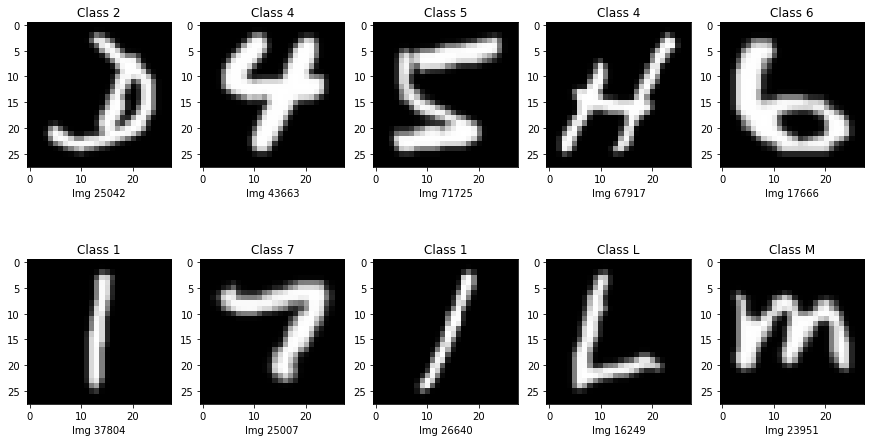

In [41]:
%matplotlib inline

# Select a 'random' subset
random.seed(112358)
sample = np.arange(raw_test_X.shape[0])
np.random.shuffle(sample)
sample = sample[0:10]

# Format for input into network
results = np.round(model.predict(test_X[sample], verbose=1), decimals=2)
resultLabels = np.argmax(results, axis=1)

# plt.imshow(raw_train_X[55].T, cmap='gray')

fig=plt.figure(figsize=(15, 8))
for i in range(10):
    fig.add_subplot(2, 5, i+1, aspect='equal')
    plt.imshow(raw_test_X[sample[i]].T, cmap='gray')
    plt.title('Class {}'.format(labels[resultLabels[i]]))
    plt.xlabel("Img {}".format(sample[i]))

In [28]:
print(resultLabels)

[32 49  2 25  7 29 25 25  2  0]
